In [1]:
import numpy as np
import pandas as pd
import subprocess
import sys
from numba import njit
import matplotlib.pyplot as plt
import os
import glob
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,10)
import json
import time

spec_home="/home/himanshu/spec/my_spec"

In [2]:
def read_dat_file(file_name):
  cols_names = []

  temp_file = "./temp.csv"
  with open(file_name,'r') as f:
    with open(temp_file,'w') as w:
      lines = f.readlines()
      for line in lines:
        if(line[0] != '#'): # This is data
          w.writelines(line)
        if(line[0:3] == '# [' or line[0:4] == '#  ['): # Some dat files have comments on the top
          cols_names.append(line.split('=')[-1][1:-1].strip())


  return pd.read_csv(temp_file,delim_whitespace=True,names=cols_names)

def plot_and_save(data,x_arr,y_arr,save_folder,file_name):
  for x_axis,y_axis in zip(x_arr,y_arr):
    plt.plot(data[x_axis],data[y_axis])
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    title = file_name[:-4]+" \""+y_axis+"\" vs \""+x_axis+"\""
    plt.title(title)
    save_path = save_folder+title.replace("/","_")
    print(f"Plotted: {save_path}" )
    print(os.getcwd())

    plt.savefig(save_path)
    plt.clf()



def read_dat_file_across_AA(file_pattern):

  path_pattern = file_pattern
  path_collection = []


  for folder_name in glob.iglob(path_pattern, recursive=True):
      if os.path.isdir(folder_name) or os.path.isfile(folder_name):
          path_collection.append(folder_name)
          print(folder_name)


  read_data_collection = []
  for path in path_collection:
    read_data_collection.append(read_dat_file(path))

  data = pd.concat(read_data_collection)
  # print(data.columns)
  return data

def read_AH_files(Ev_path):
  fileA = Ev_path + "Run/ApparentHorizons/AhA.dat"
  fileB = Ev_path + "Run/ApparentHorizons/AhB.dat"

  dataA = read_dat_file_across_AA(fileA)
  dataB = read_dat_file_across_AA(fileB)

  return dataA,dataB  
# Combines all the pvd files into a single file and save it in the base folder
def combine_pvd_files(base_folder, file_pattern, output_path=None):

  if output_path is None:
    output_path = base_folder + "/GaugeVis.pvd"

  path_pattern = file_pattern
  path_collection = []


  for folder_name in glob.iglob(path_pattern, recursive=True):
      if os.path.isdir(folder_name) or os.path.isfile(folder_name):
          path_collection.append(folder_name)
          print(folder_name)


  with open(output_path,'w') as write_file:
    for i,file_path in enumerate(path_collection):
      with open(file_path,'r') as file:
        if(i==0):
          for lines in file.readlines()[:-2]:
            lines = lines.replace("GaugeVis",file_path[:-4])
            write_file.writelines(lines)

        elif (i==len(path_collection)-1):
          for lines in file.readlines()[3:]:
            lines = lines.replace("GaugeVis",file_path[:-4])
            write_file.writelines(lines)

        else:
          for lines in file.readlines()[3:-2]:
            if "</" in lines:
              continue
            lines = lines.replace("GaugeVis",file_path[:-4])
            write_file.writelines(lines)

            
def moving_average(array,avg_len):
    return np.convolve(array,np.ones(avg_len))/avg_len
    
def moving_average_valid(array,avg_len):
    return np.convolve(array,np.ones(avg_len),'valid')/avg_len


def path_to_folder_name(folder_name):
  return folder_name.replace("/","_")

# Give a dict of {"run_name" = runs_path} and data_file_path to get {"run_name" = dat_file_data}
def load_data_from_levs(runs_path, data_file_path):
  data_dict = {}
  column_list = ""
  for run_name in runs_path.keys():
    data_dict[run_name] = read_dat_file_across_AA(runs_path[run_name]+data_file_path)
    column_list = data_dict[run_name].columns
  return column_list, data_dict


def plot_graph_for_runs(runs_data_dict, x_axis, y_axis, minT, maxT, save_path=None, moving_avg_len=0, plot_fun = lambda x,y,label : plt.plot(x,y,label=label)):

  minT_indx_list={}
  maxT_indx_list={}
  
  for run_name in runs_data_dict.keys():
    minT_indx_list[run_name] = len(runs_data_dict[run_name][x_axis][runs_data_dict[run_name][x_axis] < minT])
    maxT_indx_list[run_name] = len(runs_data_dict[run_name][x_axis][runs_data_dict[run_name][x_axis] < maxT])

  if moving_avg_len == 0:

    for run_name in runs_data_dict.keys():
      x_data = runs_data_dict[run_name][x_axis][minT_indx_list[run_name]:maxT_indx_list[run_name]]
      y_data = runs_data_dict[run_name][y_axis][minT_indx_list[run_name]:maxT_indx_list[run_name]]
      plot_fun(x_data, y_data,run_name)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    title = "\"" +  y_axis+"\" vs \""+x_axis+"\""
    plt.title(title)
    plt.legend()

  else:
    for run_name in runs_data_dict.keys():
      x_data = runs_data_dict[run_name][x_axis][minT_indx_list[run_name] + moving_avg_len-1:maxT_indx_list[run_name]]
      y_data = moving_average_valid(runs_data_dict[run_name][y_axis][minT_indx_list[run_name]:maxT_indx_list[run_name]], moving_avg_len)
      plot_fun(x_data, y_data,run_name)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    title = "\"" + y_axis+ "\" vs \"" + x_axis + "\"  " + f"avg_window_len={moving_avg_len}"
    plt.title(title)
    plt.legend()

  
  if save_path is not None:
    fig_x_label = x_axis.replace("/","_")
    fig_y_label = y_axis.replace("/","_")
    save_file_name = f"{fig_y_label}_vs_{fig_x_label}_minT={minT}_maxT={maxT}_moving_avg_len={moving_avg_len}"
    for run_name in runs_data_dict.keys():
      save_file_name = save_file_name + "__" + run_name

    plt.savefig(save_path+save_file_name)


def find_file(pattern):
  return glob.glob(pattern, recursive=True)[0]

def plots_for_a_folder(things_to_plot,plot_folder_path,data_folder_path):
  for plot_info in things_to_plot:
    file_name = plot_info['file_name']
    y_arr = plot_info['columns'][1:]
    x_arr = [plot_info['columns'][0]]*len(y_arr)

    data = read_dat_file_across_AA(data_folder_path+"/**/"+file_name)
    plot_and_save(data,x_arr,y_arr,plot_folder_path,file_name)

def is_the_current_run_going_on(run_folder):
  if len(find_file(run_folder+"/**/"+"TerminationReason.txt")) > 0:
    return False
  else:
    return True


# Make report

In [29]:
with open("./report_new_gauge.json") as report_data:
  data = json.load(report_data)

os.mkdir(data['report_folder'])

subfolders = []
for folders in data['runs_to_track']:
  subfolders_path = data['report_folder'] + "/" + path_to_folder_name(folders) + "/"
  print(subfolders_path)
  os.mkdir(subfolders_path)
  subfolders.append(subfolders_path)

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/48_gd_weird_gauge_**_Lev1_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/49_gd_weird_gauge_mr3_**_Lev1_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/49_gd_weird_gauge_mr1_09_**_Lev1_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/49_ngd_weird_gauge_mr1_**_Lev1_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/49_ngd_weird_gauge_mr109_**_Lev1_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/51_master_mr1_d0_20_**_Lev1_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/51_master_mr1_d0_20_**_Lev2_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/51_master_mr1_d0_20_**_Lev3_??/
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/51_ngd_KerrSch_gauge_mr1_d0_20_3_**_Lev1_??/
/p

In [31]:
runs_still_going_on = True
while runs_still_going_on:
  # time.sleep(data['report_generation_frequency'])

  for i,run_folder_path in enumerate(data['runs_to_track']):
    # if is_the_current_run_going_on(run_folder_path) or True:
    if True:
      plots_for_a_folder(data['things_to_plot'],subfolders[i],run_folder_path)
    print(run_folder_path)


  runs_still_going_on = False
  print("all done")


48_gd_weird_gauge/Ev/Lev1_AA/Run/TStepperDiag.dat
48_gd_weird_gauge/Ev/Lev1_AB/Run/TStepperDiag.dat
48_gd_weird_gauge/Ev/Lev1_AC/Run/TStepperDiag.dat
48_gd_weird_gauge/Ev/Lev1_AD/Run/TStepperDiag.dat
48_gd_weird_gauge/Ev/Lev1_AE/Run/TStepperDiag.dat
Plotted: /panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/48_gd_weird_gauge_**_Lev1_??/TStepperDiag "error_1e-08" vs "time after step"
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs
Plotted: /panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/48_gd_weird_gauge_**_Lev1_??/TStepperDiag "NumRhsEvaluations in this segment" vs "time after step"
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs
Plotted: /panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/new_gauge_tests/48_gd_weird_gauge_**_Lev1_??/TStepperDiag "dt" vs "time after step"
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs
Plotted: /panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/ne

ValueError: No objects to concatenate

<Figure size 1000x800 with 0 Axes>

# GhCe plots

In [58]:
path = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_zero_target_100_0_100_50/Ev/Lev1_AA/Run/ConstraintNorms/GhCe_Linf.dat"

In [66]:
ghce_data = read_dat_file(path)
ghce_data.columns
ghce_data.max()

time                               99.500000
Linf(GhCe) on SphereA0              0.000401
Linf(GhCe) on SphereA1              0.000418
Linf(GhCe) on SphereA2              0.000269
Linf(GhCe) on SphereA3              0.166264
                                     ...    
Linf(GhCe) on FilledCylinderCB1     0.004289
Linf(GhCe) on FilledCylinderMB0     2.917910
Linf(GhCe) on FilledCylinderMB1    18.510802
Linf(GhCe) on CylinderSMB0.0        7.327247
Linf(GhCe) on CylinderSMB1.0       15.116933
Length: 68, dtype: float64

# Save all columns and data files paths

In [45]:

lev_golb="/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_kerr_target_50_50_0_16_16_01/Ev/Lev1_AA"
dat_files_glob=lev_golb+"/Run/**/**.dat"
path_pattern = dat_files_glob

path_collection = []
for folder_name in glob.iglob(path_pattern, recursive=True):
    if os.path.isdir(folder_name) or os.path.isfile(folder_name):
        path_collection.append(folder_name)
        print(folder_name.split("/")[-1])


column_data_for_dat_files = {
  'columns_of_dat_files' : [
  ] 
}

for file_path in path_collection:
  file_name = file_path.split("/")[-1]
  columns_list =  list(read_dat_file(file_path).columns)
  column_data_for_dat_files['columns_of_dat_files'].append({
    'file_name': file_name,
    'file_path': file_path,
    'columns': columns_list
  })


with open('./column_data_for_dat_files.json', 'w') as outfile:
  json.dump(column_data_for_dat_files, outfile, indent=2)

DiagCutXCorrection.dat
DiagAhSpeedA.dat
DiagAhSpeedB.dat
DiagInclinationAngle.dat
MinimumGridSpacing.dat
GrAdjustMaxTstepToDampingTimes.dat
OdeErrorRelative.dat
TStepperDiag.dat
GrAdjustSubChunksToDampingTimes.dat
MemoryInfo.dat
TimeInfo.dat
FailedTStepperDiag.dat
SmoothCoordSepHorizon.dat
HorizonSepMeasures.dat
MinCharSpeedAhA.dat
MinCharSpeedAhB.dat
RescaledRadAhA.dat
RescaledRadAhB.dat
AhA.dat
Trajectory_AhA.dat
AhACoefs.dat
AhB.dat
Trajectory_AhB.dat
AhBCoefs.dat
CharSpeeds_Min_SliceLFF.SphereA0.dat
CharSpeeds_Min_SliceUFF.SphereC34.dat
CharSpeeds_Min_SliceLFF.SphereB0.dat
CharSpeeds_Max_SliceLFF.SphereA0.dat
CharSpeeds_Max_SliceUFF.SphereC34.dat
CharSpeeds_Max_SliceLFF.SphereB0.dat
GhCe_Norms.dat
GhCeExt_Norms.dat
NormalizedGhCe_Norms.dat
GhCe.dat
GhCeExt.dat
GhCeExt_L2.dat
GhCe_VolL2.dat
GhCe_L2.dat
GhCe_Linf.dat
NormalizedGhCe_Linf.dat


# Run comparison plots

### gauge_driver_mr3

In [4]:
fileB = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_??/Run/ApparentHorizons/AhB.dat"

read_file_mr3B = read_dat_file_across_AA(fileB)

fileA = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_??/Run/ApparentHorizons/AhA.dat"

read_file_mr3A = read_dat_file_across_AA(fileA)

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AA/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AB/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AC/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AD/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AE/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AF/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AG/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_AH/Run/ApparentHorizons/AhB.dat
Index(['time', 'sqrt(Area/16pi)', 'Area', 'Residual', 'Normalize

### 180822_neg_dh_K2M_100_5_1_50_0_1_1

In [5]:
fileB = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_A?/Run/ApparentHorizons/AhB.dat"

read_file_k2B = read_dat_file_across_AA(fileB)

fileA = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_A?/Run/ApparentHorizons/AhA.dat"

read_file_k2A = read_dat_file_across_AA(fileA)


/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AA/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AB/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AC/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AD/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AE/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AF/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/180822_neg_dh_K2M_100_5_1_50_0_1_1/Ev/Lev0_AG/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/

### 160724_dh_tanhK_100_5_1_50_0_1_1

In [25]:

fileB = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_A?/Run/ApparentHorizons/AhB.dat"

read_file_mr3B = read_dat_file_across_AA(fileB)

fileA = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_A?/Run/ApparentHorizons/AhA.dat"

read_file_mr3A = read_dat_file_across_AA(fileA)

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AA/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AB/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AC/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AD/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AE/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AF/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/140724_dh_with_shift_fac_100_5_1_50_0_025_025/Ev/Lev3_AG/Run/App

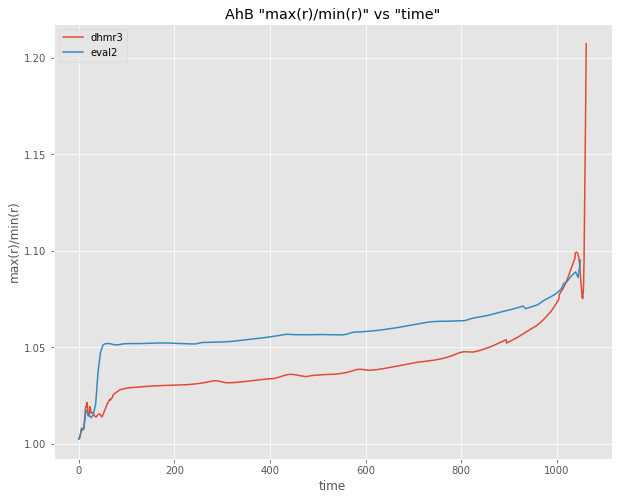

In [8]:
from cProfile import label


x_axis = "time"
y_label = "max(r)/min(r)"

plt.plot(read_file_mr3A[x_axis],read_file_mr3A["max(r)"]/read_file_mr3A["min(r)"],label="dhmr3")
plt.plot(read_file_k2A[x_axis],read_file_k2A["max(r)"]/read_file_k2A["min(r)"],label="eval2")
plt.xlabel(x_axis)
plt.ylabel(y_label)
title = "AhB"+" \""+y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()

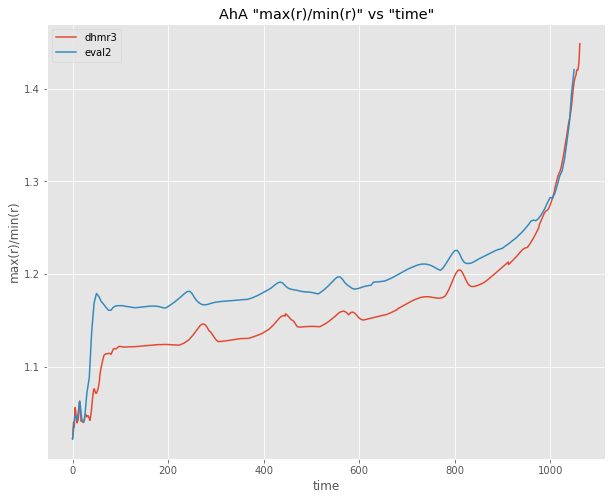

In [9]:
from cProfile import label


x_axis = "time"
y_label = "max(r)/min(r)"

plt.plot(read_file_mr3B[x_axis],read_file_mr3B["max(r)"]/read_file_mr3B["min(r)"],label="dhmr3")
plt.plot(read_file_k2B[x_axis],read_file_k2B["max(r)"]/read_file_k2B["min(r)"],label="eval2")
plt.xlabel(x_axis)
plt.ylabel(y_label)
title = "AhA"+" \""+y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()

In [69]:
read_file.columns

Index(['time', 'sqrt(Area/16pi)', 'Area', 'Residual', 'NormalizedResidual',
       'min(r)', 'max(r)', 'Center_x', 'Center_y', 'Center_z',
       'min(|r^i-c^i|)', 'max(|r^i-c^i|)', 'convg reason', 'NumIterations',
       'min(R_ij)', 'max(R_ij)', 'L_surface', 'L_mesh', 'L_max',
       'Shape_TruncationError', 'Shape_NumberOfPiledUpModes'],
      dtype='object')

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AA/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AB/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AE/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AA/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AB/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/ApparentHorizons/AhB.dat
/

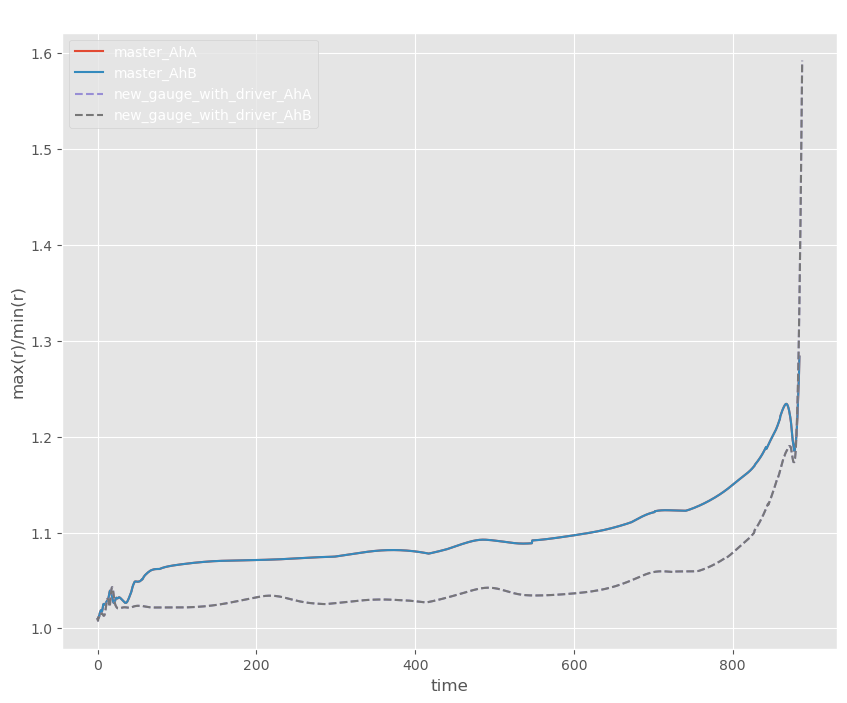

In [15]:
from cProfile import label
run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/4_2908_KerrH_1_1_50_0_50_0_1_1_3/Ev/Lev0_A?/"
run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/49_ngd_weird_gauge_mr1/Ev/Lev1_A?/"

run1_dataA,run1_dataB = read_AH_files(run1)
run2_dataA,run2_dataB = read_AH_files(run2)

x_axis = "time"
y_label = "max(r)/min(r)"

maxT = 1200
max_indx1 = len(run1_dataA["time"][run1_dataA["time"] < maxT])
max_indx2 = len(run2_dataA["time"][run2_dataA["time"] < maxT])


plt.plot(run1_dataA[x_axis][:max_indx1],run1_dataA["max(r)"][:max_indx1]/run1_dataA["min(r)"][:max_indx1],label="master_AhA")
plt.plot(run1_dataB[x_axis][:max_indx1],run1_dataB["max(r)"][:max_indx1]/run1_dataB["min(r)"][:max_indx1],label="master_AhB")
plt.plot(run2_dataA[x_axis][:max_indx2],run2_dataA["max(r)"][:max_indx2]/run2_dataA["min(r)"][:max_indx2],label="new_gauge_with_driver_AhA",linestyle="dashed")
plt.plot(run2_dataB[x_axis][:max_indx2],run2_dataB["max(r)"][:max_indx2]/run2_dataB["min(r)"][:max_indx2],label="new_gauge_with_driver_AhB",linestyle="dashed")


plt.xlabel(x_axis)
plt.ylabel(y_label)
title = y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()
plt.savefig("/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_weird_gauge_vs_master_mr1/"+run1.split("/")[-4]+"@@@"+run2.split("/")[-4]+"_"+f"max(r)_min(r)_{max_indx1}")

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AA/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AB/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AE/Run/ApparentHorizons/AhA.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AA/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AB/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/ApparentHorizons/AhB.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/ApparentHorizons/AhB.dat
/

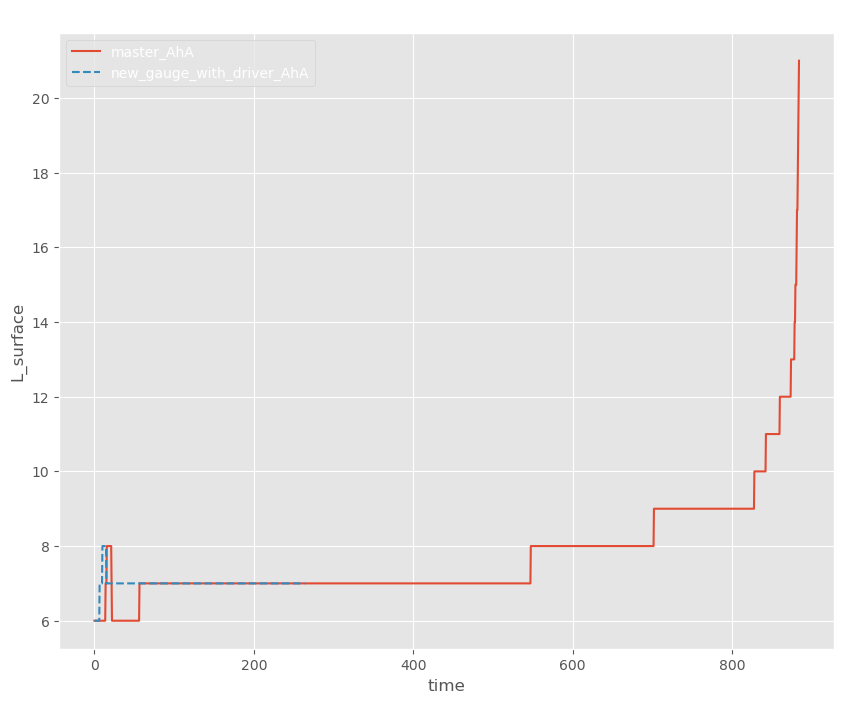

In [7]:
from cProfile import label
run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/49_ngd_weird_gauge_mr1/Ev/Lev1_A?/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/53_gd_DGGauge_mr1/Ev/Lev1_A?/"
run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr1/Ev/Lev1_A?/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/54_gd_DGGaugeReduced_mr1/Ev/Lev1_A?/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_1/Ev/Lev1_A?/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/4_2908_KerrH_1_1_50_0_50_0_1_1_3/Ev/Lev0_A?/"

run1_dataA,run1_dataB = read_AH_files(run1)
run2_dataA,run2_dataB = read_AH_files(run2)

x_axis = "time"
y_label = "L_surface"

max_indx = 26000

plt.plot(run1_dataA[x_axis][:max_indx],run1_dataA[y_label][:max_indx],label="master_AhA")
# plt.plot(run1_dataB[x_axis][:max_indx],run1_dataB[y_label][:max_indx],label="master_AhB")
plt.plot(run2_dataA[x_axis],run2_dataA[y_label],label="new_gauge_with_driver_AhA",linestyle="dashed")
# plt.plot(run2_dataB[x_axis],run2_dataB[y_label],label="new_gauge_with_driver_AhB",linestyle="dashed")


plt.xlabel(x_axis)
plt.ylabel(y_label)
title = y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()
plt.savefig("/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_weird_gauge_vs_master_mr1/"+run1.split("/")[-4]+"@@@"+run2.split("/")[-4]+"_"+f"max(r)_min(r)_{max_indx}")

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AA/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AB/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AE/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_AA/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_AB/Run/ApparentHorizons/SmoothCoordSepHorizon.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Le

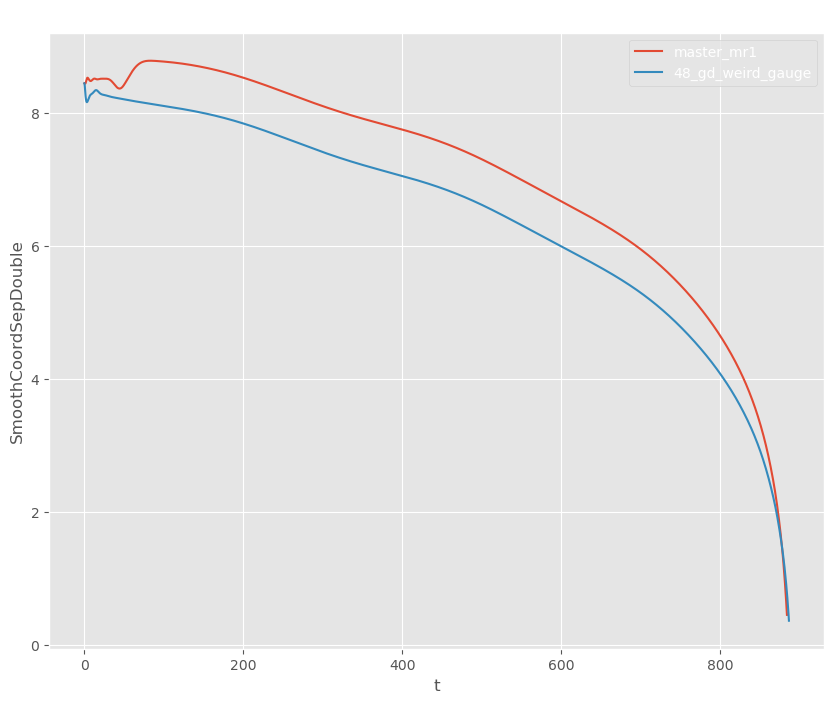

In [42]:
from cProfile import label
run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/Run/"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev1_A?/Run/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev1_A?/Run/"
run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/Run/"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/54_gd_DGGaugeReduced_mr1/Ev/Lev1_A?/Run/"

# file = "ApparentHorizons/Trajectory_AhA.dat"
# # ['time', 'InertialCenter_x', 'InertialCenter_y', 'InertialCenter_z']
# x_axis = "time"
# y_label = "InertialCenter_z"

file = "ApparentHorizons/SmoothCoordSepHorizon.dat"
# ['t', 'SmoothCoordSepDouble']
x_axis = "t"
y_label = "SmoothCoordSepDouble"



run1 = run1+file
run2 = run2+file
run1_dataA = read_dat_file_across_AA(run1)
run2_dataA = read_dat_file_across_AA(run2)
print(run1_dataA.columns)


minT = 0
maxT = 2000
max_indx1 = len(run1_dataA[x_axis][run1_dataA[x_axis] < maxT])
max_indx2 = len(run2_dataA[x_axis][run2_dataA[x_axis] < maxT])
min_indx1 = len(run1_dataA[x_axis][run1_dataA[x_axis] < minT])
min_indx2 = len(run2_dataA[x_axis][run2_dataA[x_axis] < minT])

plt.plot(run1_dataA[x_axis][min_indx1:max_indx1],run1_dataA[y_label][min_indx1:max_indx1],label=run1.split("/")[8])
plt.plot(run2_dataA[x_axis][min_indx2:max_indx2],run2_dataA[y_label][min_indx2:max_indx2],label=run2.split("/")[8])
# plt.scatter(run1_dataA[x_axis][min_indx1:max_indx1],run1_dataA[y_label][min_indx1:max_indx1],label=run1.split("/")[8],linewidths=0.1)
# plt.scatter(run2_dataA[x_axis][min_indx2:max_indx2],run2_dataA[y_label][min_indx2:max_indx2],label=run2.split("/")[8],linewidths=0.1)

# avg_len=100
# x_data1 = run1_dataA[x_axis][min_indx1+avg_len-1:max_indx1]
# y_data1 = moving_average_valid(run1_dataA[y_label][min_indx1:max_indx1],avg_len)
# x_data2 = run2_dataA[x_axis][min_indx2+avg_len-1:max_indx2]
# y_data2 = moving_average_valid(run2_dataA[y_label][min_indx2:max_indx2],avg_len)
# plt.plot(x_data1,y_data1,label=run1.split("/")[8],linestyle="dotted")
# plt.plot(x_data2,y_data2,label=run2.split("/")[8],linestyle="dotted")

plt.xlabel(x_axis)
plt.ylabel(y_label)
title = y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()


fig_x_label = x_axis.replace("/","_")
fig_y_label = y_label.replace("/","_")
plt.savefig(f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_weird_gauge_vs_master_mr1/{fig_y_label}_vs_{fig_x_label}_"+run1.split("/")[-4]+"@@@"+run2.split("/")[-4]+"_"+f"T_t_{max_indx1}")

In [42]:
def load_data_from_levs(runs_path, data_file_path):
  data_dict = {}
  column_list = ""
  for run_name in runs_path.keys():
    data_dict[run_name] = read_dat_file_across_AA(runs_path[run_name]+data_file_path)
    column_list = data_dict[run_name].columns
  return column_list, data_dict


def plot_graph_for_runs(runs_data_dict, x_axis, y_axis, minT, maxT, save_path=None, moving_avg_len=0, plot_fun = lambda x,y,label : plt.plot(x,y,label=label)):

  minT_indx_list={}
  maxT_indx_list={}
  
  for run_name in runs_data_dict.keys():
    minT_indx_list[run_name] = len(runs_data_dict[run_name][x_axis][runs_data_dict[run_name][x_axis] < minT])
    maxT_indx_list[run_name] = len(runs_data_dict[run_name][x_axis][runs_data_dict[run_name][x_axis] < maxT])

  if moving_avg_len == 0:

    for run_name in runs_data_dict.keys():
      x_data = runs_data_dict[run_name][x_axis][minT_indx_list[run_name]:maxT_indx_list[run_name]]
      y_data = runs_data_dict[run_name][y_axis][minT_indx_list[run_name]:maxT_indx_list[run_name]]
      plot_fun(x_data, y_data,run_name)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    title = "\"" +  y_axis+"\" vs \""+x_axis+"\""
    plt.title(title)
    plt.legend()

  else:
    for run_name in runs_data_dict.keys():
      x_data = runs_data_dict[run_name][x_axis][minT_indx_list[run_name] + moving_avg_len-1:maxT_indx_list[run_name]]
      y_data = moving_average_valid(runs_data_dict[run_name][y_axis][minT_indx_list[run_name]:maxT_indx_list[run_name]], moving_avg_len)
      plot_fun(x_data, y_data,run_name)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    title = "\"" + y_label+ "\" vs \"" + x_axis + "\"  " + f"avg_window_len={moving_avg_len}"
    plt.title(title)
    plt.legend()

  
  if save_path is not None:
    fig_x_label = x_axis.replace("/","_")
    fig_y_label = y_axis.replace("/","_")
    save_file_name = f"{fig_y_label}_vs_{fig_x_label}_minT={minT}_maxT={maxT}_moving_avg_len={moving_avg_len}"
    for run_name in runs_data_dict.keys():
      save_file_name = save_file_name + "__" + run_name

    plt.savefig(save_path+save_file_name)


# Plot runs

In [6]:
runs_to_plot = {}
# runs_to_plot["master_mr1_Lev1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["master_mr1_Lev3"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev3_A?/Run/"
# runs_to_plot["21_gauge_driver_Kerr_H_1_1_1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/21_gauge_driver_Kerr_H_1_1_1/Ev/Lev1_A?/Run/"
# runs_to_plot["21_gauge_driver_Kerr_H_1_16_16"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/21_gauge_driver_Kerr_H_1_16_16/Ev/Lev1_A?/Run/"
# runs_to_plot["21_gauge_driver_Kerr_H_1_16_1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/21_gauge_driver_Kerr_H_1_16_1/Ev/Lev1_A?/Run/"
# runs_to_plot["21_gauge_driver_Kerr_H_1_1_16"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/21_gauge_driver_Kerr_H_1_1_16/Ev/Lev1_A?/Run/"
# runs_to_plot["21_gauge_driver_Kerr_H_1_02_02"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/21_gauge_driver_Kerr_H_1_02_02/Ev/Lev1_A?/Run/"
# runs_to_plot["21_gauge_driver_Kerr_H_1_01_1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/21_gauge_driver_Kerr_H_1_01_1/Ev/Lev1_A?/Run/"
# runs_to_plot["one_high_spin_zero_ecc_equal_mass_Lev1"] = "/panfs/ds09/sxs/himanshu/runs/simple_BBH_for_GH_testing/one_high_spin_zero_ecc_equal_mass/Ev/Lev1_A?/Run/"
# runs_to_plot["one_high_spin_zero_ecc_equal_mass_Lev3"] = "/panfs/ds09/sxs/himanshu/runs/simple_BBH_for_GH_testing/one_high_spin_zero_ecc_equal_mass/Ev/Lev3_A?/Run/"
# runs_to_plot["zero_spin_zero_ecc_mr_10_Lev1"] = "/panfs/ds09/sxs/himanshu/runs/simple_BBH_for_GH_testing/zero_spin_zero_ecc_mr_10/Ev/Lev1_A?/Run/"
# runs_to_plot["zero_spin_zero_ecc_mr_10_Lev2"] = "/panfs/ds09/sxs/himanshu/runs/simple_BBH_for_GH_testing/zero_spin_zero_ecc_mr_10/Ev/Lev2_A?/Run/"
# runs_to_plot["zero_spin_zero_ecc_mr_10_Lev3"] = "/panfs/ds09/sxs/himanshu/runs/simple_BBH_for_GH_testing/zero_spin_zero_ecc_mr_10/Ev/Lev3_A?/Run/"
# runs_to_plot["gauge_driver_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["gauge_driver_mr3"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_A?/Run/"
# runs_to_plot["gauge_driver_mr10_Lev1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr10/Ev/Lev1_A?/Run/"
# runs_to_plot["gauge_driver_mr10_Lev2"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr10/Ev/Lev2_A?/Run/"
# runs_to_plot["gauge_driver_mr10_Lev3"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr10/Ev/Lev3_A?/Run/"
# runs_to_plot["48_gd_weird_gauge"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_64_64"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_64_64/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_32_32"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_32_32/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_8_8"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_8_8/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_64_16"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_64_16/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_16_64"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_16_64/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_4_4"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_4_4/Lev1_A?/Run/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_4_4_1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_4_4_1/Lev1_A?/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_4_4_2"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_4_4_2/Lev1_A?/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_4_4_105"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_4_4_105/Lev1_A?/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_4_4_07"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_4_4_07/Lev1_A?/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_4_4_03"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_4_4_03/Lev1_A?/"
# runs_to_plot["48_gd_weird_gauge_Lev1AB_1_1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1AB_1_1/Lev1_A?/Run/"
# runs_to_plot["49_ngd_weird_gauge_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/49_ngd_weird_gauge_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["51_master_mr1_d0_20_Lev1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev1_A?/Run/"
# runs_to_plot["51_master_mr1_d0_20_Lev2"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev2_A?/Run/"
# runs_to_plot["51_master_mr1_d0_20_Lev3"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_A?/Run/"
# runs_to_plot["51_ngd_KerrSch_gauge_mr1_d0_20_3_Lev1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev1_A?/Run/"
# runs_to_plot["51_ngd_KerrSch_gauge_mr1_d0_20_3_Lev2"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev2_A?/Run/"
# runs_to_plot["51_ngd_KerrSch_gauge_mr1_d0_20_3_Lev3"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev3_A?/Run/"
# runs_to_plot["53_gd_DGGauge_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/53_gd_DGGauge_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["54_gd_DGGaugeReduced_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/54_gd_DGGaugeReduced_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["55_gd_DHHarmonic_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["56_gd_MaxDHHarmonic_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/56_gd_MaxDHHarmonic_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["57_gd_MaxDH3Harmonic_mr1"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/57_gd_MaxDH3Harmonic_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["58_gd_NShiftDH3Harmonic"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/58_gd_NShiftDH3Harmonic/Ev/Lev1_A?/Run/"
# runs_to_plot["59_gd_DHbare"] = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/59_gd_DHbare/Ev/Lev1_A?/Run/"
# runs_to_plot["62_KerrSchGrid_mr1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/62_KerrSchGrid_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["63_KerrSchGrid_roll_on_mr1_4_4_3"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/63_KerrSchGrid_roll_on_mr1_4_4_3/Ev/Lev1_A?/Run/"
# runs_to_plot["63_KerrSchGrid_roll_on_mr1_16_16_3"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/63_KerrSchGrid_roll_on_mr1_16_16_3/Ev/Lev1_A?/Run/"
# runs_to_plot["63_KerrSchGrid_roll_on_mr1_4_4_1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/63_KerrSchGrid_roll_on_mr1_4_4_1/Ev/Lev1_A?/Run/"
# runs_to_plot["64_KerrSchInert_roll_on_mr1_4_4_3"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/64_KerrSchInert_roll_on_mr1_4_4_3/Ev/Lev1_A?/Run/"
# runs_to_plot["64_KerrSchInert_roll_on_mr1_16_16_1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/64_KerrSchInert_roll_on_mr1_16_16_1/Ev/Lev1_A?/Run/"
# runs_to_plot["64_KerrSchInert_roll_on_mr1_16_16_05"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/64_KerrSchInert_roll_on_mr1_16_16_05/Ev/Lev1_A?/Run/"
# runs_to_plot["64_KerrSchInert_roll_on_mr1_4_4_1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/64_KerrSchInert_roll_on_mr1_4_4_1/Ev/Lev1_A?/Run/"
# runs_to_plot["64_KerrSchInert_roll_on_mr1_4_4_05_Lev1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/64_KerrSchInert_roll_on_mr1_4_4_05/Ev/Lev1_A?/Run/"
# runs_to_plot["64_KerrSchInert_roll_on_mr1_4_4_05_Lev3"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/64_KerrSchInert_roll_on_mr1_4_4_05/Ev/Lev3_A?/Run/"
# runs_to_plot["65_KerrSchGrid_roll_on_mr1_4_4_05"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/65_KerrSchGrid_roll_on_mr1_4_4_05/Ev/Lev1_A?/Run/"
# runs_to_plot["65_KerrSchGrid_roll_on_mr1_16_16_05"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/65_KerrSchGrid_roll_on_mr1_16_16_05/Ev/Lev1_A?/Run/"
# runs_to_plot["65_KerrSchGrid_roll_on_mr1_4_4_01"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/65_KerrSchGrid_roll_on_mr1_4_4_01/Ev/Lev1_A?/Run/"
# runs_to_plot["66_master_harmonic_mr1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/66_master_harmonic_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["66_master_harmonic_mr1_09Spin"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/66_master_harmonic_mr1_09Spin/Ev/Lev1_A?/Run/"
# runs_to_plot["66_master_harmonic_mr3"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/66_master_harmonic_mr3/Ev/Lev1_A?/Run/"
# runs_to_plot["66_master_harmonic_mr1_05Spin"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/66_master_harmonic_mr1_05Spin/Ev/Lev1_A?/Run/"
# runs_to_plot["66_master_harmonic_mr3_05Spin"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/66_master_harmonic_mr3_05Spin/Ev/Lev1_A?/Run/"
# runs_to_plot["67_master_mr1"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/67_master_mr1/Ev/Lev1_A?/Run/"
# runs_to_plot["67_master_mr1_09Spin"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/67_master_mr1_09Spin/Ev/Lev1_A?/Run/"
# runs_to_plot["67_master_mr3"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/67_master_mr3/Ev/Lev1_A?/Run/"
# runs_to_plot["67_master_mr1_05Spin"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/67_master_mr1_05Spin/Ev/Lev1_A?/Run/"
# runs_to_plot["67_master_mr3_05Spin"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/67_master_mr3_05Spin/Ev/Lev1_A?/Run/"
# runs_to_plot["68_master_mr1_200_0"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/68_master_mr1_200_0/Ev/Lev1_A?/Run/"
# runs_to_plot["68_master_mr1_50_200"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/68_master_mr1_50_200/Ev/Lev1_A?/Run/"
# runs_to_plot["68_master_mr1_50_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/68_master_mr1_50_400/Ev/Lev1_A?/Run/"
# runs_to_plot["68_master_mr1_200_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/68_master_mr1_200_400/Ev/Lev1_A?/Run/"
# runs_to_plot["68_master_mr1_25_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/68_master_mr1_25_400/Ev/Lev1_A?/Run/"
# runs_to_plot["69_gd_master_mr1_200_0"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/69_gd_master_mr1_200_0/Ev/Lev1_A?/Run/"
# runs_to_plot["69_gd_master_mr1_50_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/69_gd_master_mr1_50_400/Ev/Lev1_A?/Run/"
# runs_to_plot["69_gd_master_mr1_200_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/69_gd_master_mr1_200_400/Ev/Lev1_A?/Run/"
# runs_to_plot["69_ngd_harmonic_mr1_200_0"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/69_ngd_harmonic_mr1_200_0/Ev/Lev1_A?/Run/"
# runs_to_plot["69_ngd_harmonic_mr1_50_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/69_ngd_harmonic_mr1_50_400/Ev/Lev1_A?/Run/"
# runs_to_plot["69_ngd_harmonic_mr1_200_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/69_ngd_harmonic_mr1_200_400/Ev/Lev1_A?/Run/"
# runs_to_plot["70_ngd_master_harmonic_mr1_50_400_old"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_harmonic_mr1_50_400/Ev/old_Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_harmonic_mr1_200_400_old"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_harmonic_mr1_200_400/Ev/old_Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_mr1_50_400_old"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_mr1_50_400/Ev/old_Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_mr1_200_400_old"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_mr1_200_400/Ev/old_Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_harmonic_mr1_50_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_harmonic_mr1_50_400/Ev/Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_harmonic_mr1_200_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_harmonic_mr1_200_400/Ev/Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_mr1_50_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_mr1_50_400/Ev/old_Lev3_A?/Run/"
# runs_to_plot["70_ngd_master_mr1_200_400"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/70_ngd_master_mr1_200_400/Ev/Lev3_A?/Run/"
runs_to_plot["master_mr1_nodes_check_1_Ev"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/1_Ev/Lev1_A?/Run/"
runs_to_plot["master_mr1_nodes_check_3_Ev"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/3_Ev/Lev1_A?/Run/"
runs_to_plot["master_mr1_nodes_check_4_Ev"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/4_Ev/Lev1_A?/Run/"
runs_to_plot["master_mr1_nodes_check_5_Ev"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/5_Ev/Lev1_A?/Run/"
# runs_to_plot["71_ngd_master_mr1_50_400_no_roll_on"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/71_ngd_master_mr1_50_400_no_roll_on/Ev/Lev3_A?/Run/"
# runs_to_plot["71_ngd_master_mr1_200_400_no_roll_on"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/71_ngd_master_mr1_200_400_no_roll_on/Ev/Lev3_A?/Run/"
# runs_to_plot["72_ngd_master_mr1_50_400_no_roll_on_pow2"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/72_ngd_master_mr1_50_400_no_roll_on_pow2/Ev/Lev3_A?/Run/"
# runs_to_plot["72_ngd_master_mr1_200_400_no_roll_on_pow2"] =  "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/72_ngd_master_mr1_200_400_no_roll_on_pow2/Ev/Lev3_A?/Run/"

# data_file_path="ConstraintNorms/GhCe_Norms.dat"
# data_file_path="ApparentHorizons/AhA.dat"
# data_file_path="ApparentHorizons/Trajectory_AhA.dat"
# data_file_path="ApparentHorizons/HorizonSepMeasures.dat"
# data_file_path="TStepperDiag.dat"
data_file_path="TimeInfo.dat"

column_names, runs_data_dict = load_data_from_levs(runs_to_plot,data_file_path)
print(column_names)

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/1_Ev/Lev1_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/1_Ev/Lev1_AB/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/3_Ev/Lev1_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/3_Ev/Lev1_AB/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/4_Ev/Lev1_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/4_Ev/Lev1_AB/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/5_Ev/Lev1_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1_nodes_check/5_Ev/Lev1_AB/Run/TimeInfo.dat
Index(['t', 'DayOfYear', 'Nprocs', 'T [hours]', 'CPU-h', 't/T', 'dt/dT',
       'CPU-h/t', 'dCPU

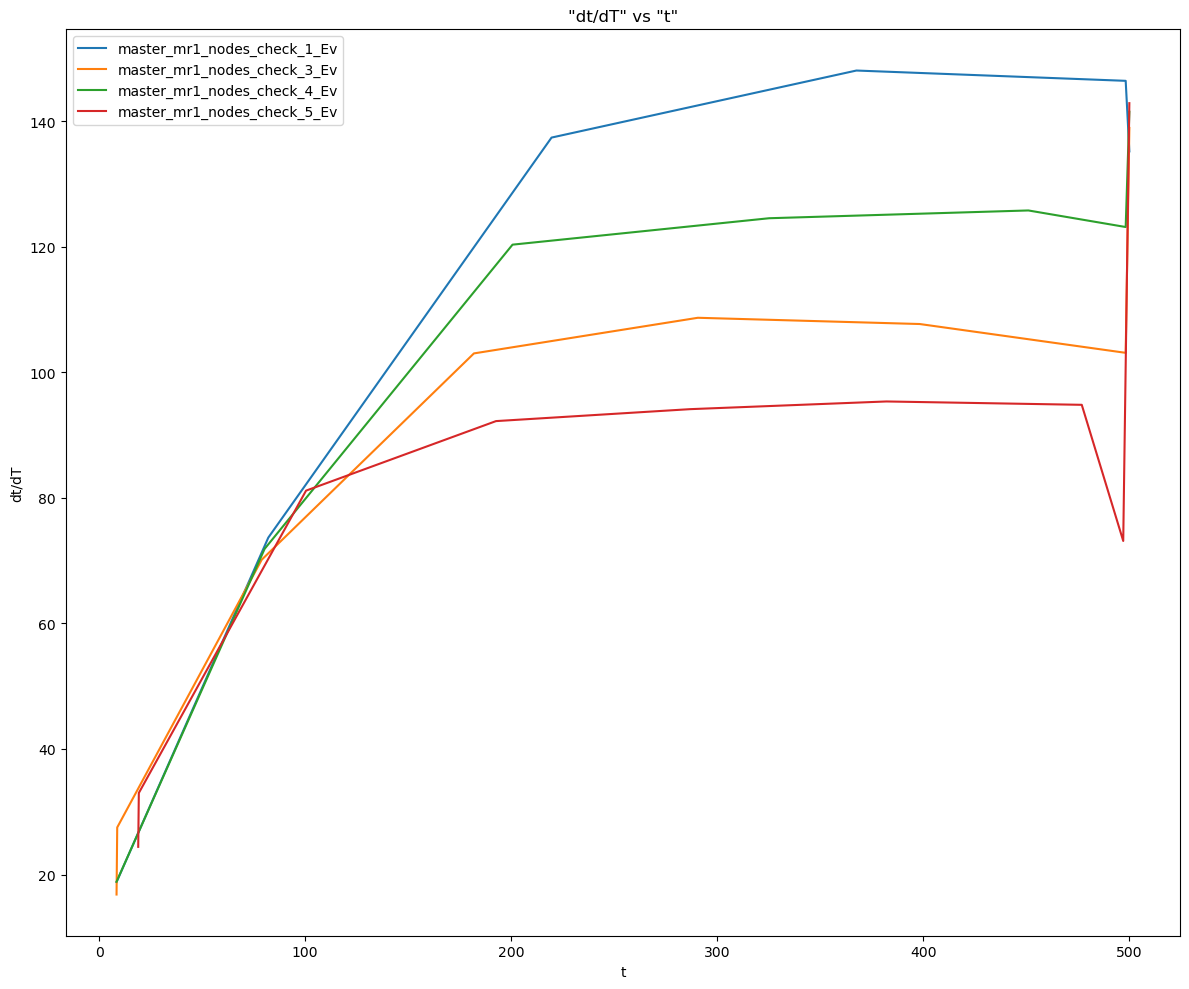

In [8]:
# x_axis = 'time'
# y_axis = 'Linf(GhCe)'


x_axis = 'T [hours]'
y_axis = 't'

x_axis = 't'
y_axis = 'dt/dT'


# x_axis = 'time'
# y_axis = 'L_surface'

# x_axis = 'time after step'
# y_axis = 'dt'

moving_avg_len=0

minT = 0
maxT = 20000

plot_fun = lambda x,y,label : plt.plot(x,y,label=label)
# plot_fun = lambda x,y,label : plt.semilogy(x,y,label=label)
# plot_fun = lambda x,y,label : plt.loglog(x,y,label=label)
# plot_fun = lambda x,y,label : plt.scatter(x,y,label=label)
save_path = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_comparison_graphs/new/"

with plt.style.context('default'):
  plt.rcParams["figure.figsize"] = (12,10)
  plt.rcParams["figure.autolayout"] = True
  plot_graph_for_runs(runs_data_dict, x_axis, y_axis, minT, maxT, save_path=save_path, moving_avg_len=moving_avg_len, plot_fun=plot_fun)

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AB/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AE/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AF/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr1/Ev/Lev1_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr1/Ev/Lev1_AB/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr1/Ev/Lev1_AC/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr

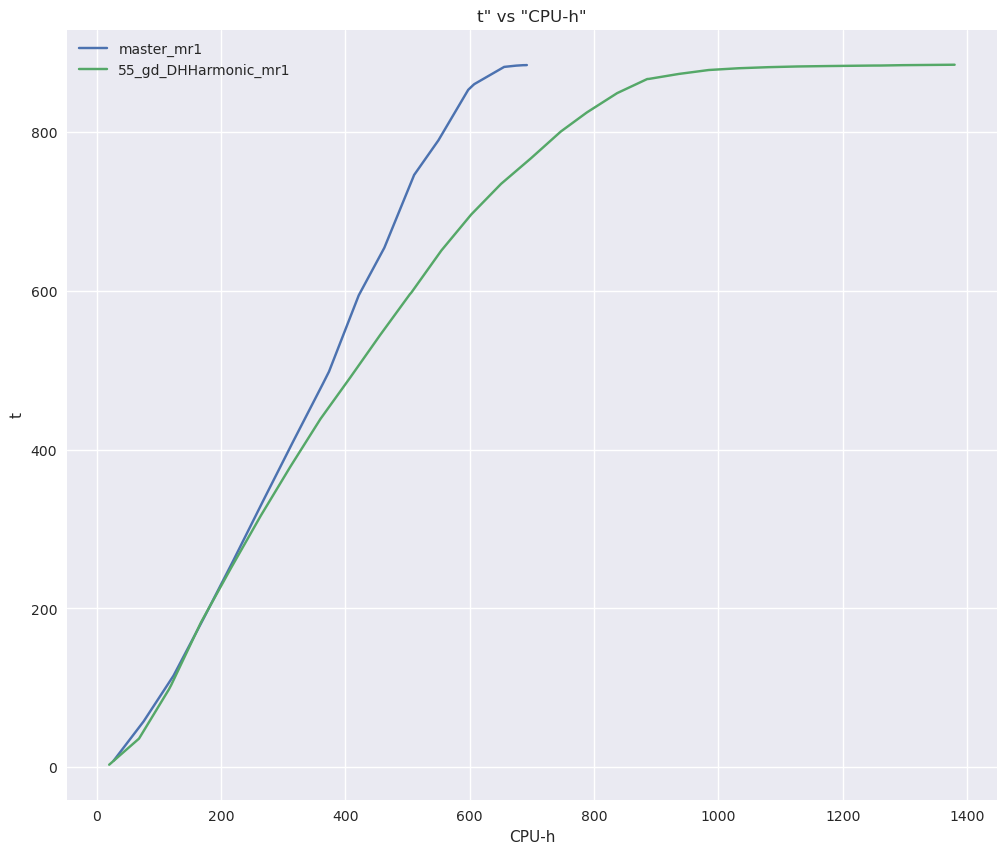

In [22]:
from cProfile import label
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_A?/Run/ConstraintNorms/GhCe_Norms.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev3_A?/Run/ConstraintNorms/GhCe_Norms.dat"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/Run/ConstraintNorms/GhCe_Norms.dat"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/Run/ConstraintNorms/GhCe_Norms.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/49_ngd_weird_gauge_mr1/Ev/Lev1_A?/Run/ConstraintNorms/GhCe_Norms.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/53_gd_DGGauge_mr1/Ev/Lev1_A?/Run/ConstraintNorms/GhCe_Norms.dat"

# x_axis = "time"
# y_label = "Linf(GhCe)"

# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev3_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/53_gd_DGGauge_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_A?/Run/TStepperDiag.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev3_A?/Run/TStepperDiag.dat"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/Run/TStepperDiag.dat"
run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/54_gd_DGGaugeReduced_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/55_gd_DHHarmonic_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/53_gd_DGGauge_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_1/Ev/Lev1_A?/Run/TimeInfo.dat"

run1_dataA = read_dat_file_across_AA(run1)
run2_dataA = read_dat_file_across_AA(run2)

run1_dataA.columns

x_axis = "CPU-h"
# x_axis = "t"
# y_label = "dt/dT"
# y_label = "dCPU-h/dt"
y_label = "t"

# x_axis = "time after step"
# y_label = "dt"
# y_label = "error/1e-08"

minT = 0
maxT = 2000
max_indx1 = len(run1_dataA[x_axis][run1_dataA[x_axis] < maxT])
max_indx2 = len(run2_dataA[x_axis][run2_dataA[x_axis] < maxT])
min_indx1 = len(run1_dataA[x_axis][run1_dataA[x_axis] < minT])
min_indx2 = len(run2_dataA[x_axis][run2_dataA[x_axis] < minT])

plt.plot(run1_dataA[x_axis][min_indx1:max_indx1],run1_dataA[y_label][min_indx1:max_indx1],label=run1.split("/")[8])
plt.plot(run2_dataA[x_axis][min_indx2:max_indx2],run2_dataA[y_label][min_indx2:max_indx2],label=run2.split("/")[8])
# plt.scatter(run1_dataA[x_axis][min_indx1:max_indx1],run1_dataA[y_label][min_indx1:max_indx1],label=run1.split("/")[8],linewidths=0.1)
# plt.scatter(run2_dataA[x_axis][min_indx2:max_indx2],run2_dataA[y_label][min_indx2:max_indx2],label=run2.split("/")[8],linewidths=0.1)

# avg_len=10
# x_data1 = run1_dataA[x_axis][min_indx1+avg_len-1:max_indx1]
# y_data1 = moving_average_valid(run1_dataA[y_label][min_indx1:max_indx1],avg_len)
# x_data2 = run2_dataA[x_axis][min_indx2+avg_len-1:max_indx2]
# y_data2 = moving_average_valid(run2_dataA[y_label][min_indx2:max_indx2],avg_len)
# plt.plot(x_data1,y_data1,label=run1.split("/")[8],linestyle="dotted")
# plt.plot(x_data2,y_data2,label=run2.split("/")[8],linestyle="dotted")

plt.xlabel(x_axis)
plt.ylabel(y_label)
title = y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()


fig_x_label = x_axis.replace("/","_")
fig_y_label = y_label.replace("/","_")
plt.savefig(f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_weird_gauge_vs_master_mr1/{fig_y_label}_vs_{fig_x_label}_"+run1.split("/")[-4]+"@@@"+run2.split("/")[-4]+"_"+f"T_t_{max_indx1}")

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AC/Run/ApparentHorizons/HorizonSepMeasures.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AD/Run/ApparentHorizons/HorizonSepMeasures.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_AE/Run/ApparentHorizons/HorizonSepMeasures.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_05/Ev/Lev1_AC/Run/ApparentHorizons/HorizonSepMeasures.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_05/Ev/Lev1_AD/Run/ApparentHorizons/HorizonSepMeasures.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_05/Ev/Lev1_AE/Run/ApparentHorizons/HorizonSepMeasures.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_05/Ev/Lev1_AF/Run/ApparentHorizons/HorizonSepMeasures.dat


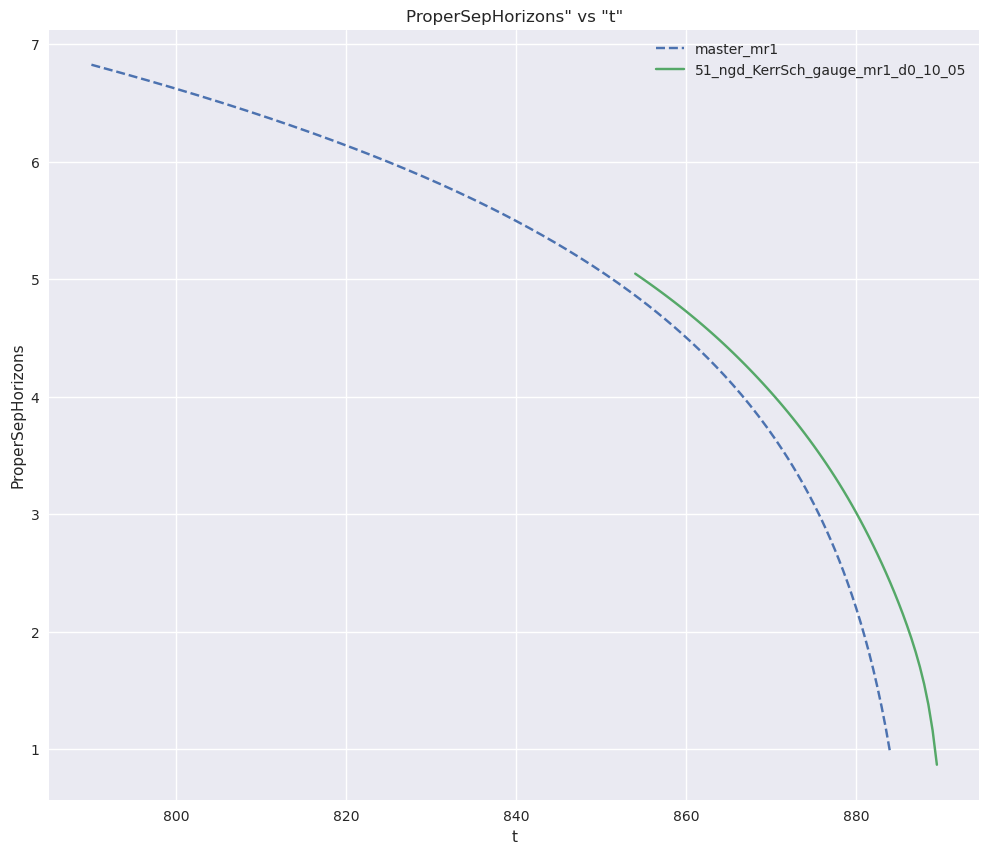

In [23]:
from cProfile import label
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/4_2908_KerrH_1_1_50_0_50_0_1_1_3/Ev/Lev0_A?/Run/TimeInfo.dat"
run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A[C-Z]/Run/ApparentHorizons/HorizonSepMeasures.dat"
run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_05/Ev/Lev1_A[C-Z]/Run/ApparentHorizons/HorizonSepMeasures.dat"

run1_dataA = read_dat_file_across_AA(run1)
run2_dataA = read_dat_file_across_AA(run2)

x_axis = "t"
# y_label = "dt/dT"
# y_label = "dCPU-h/dt"
y_label = "ProperSepHorizons"

maxT = 1200
max_indx1 = len(run1_dataA["t"][run1_dataA["t"] < maxT])
max_indx2 = len(run2_dataA["t"][run2_dataA["t"] < maxT])

plt.plot(run1_dataA[x_axis][:max_indx1],run1_dataA[y_label][:max_indx1],label=run1.split("/")[8],linestyle="dashed")
plt.plot(run2_dataA[x_axis][:max_indx2],run2_dataA[y_label][:max_indx2],label=run2.split("/")[8])


plt.xlabel(x_axis)
plt.ylabel(y_label)
title = y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()
plt.savefig("/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_weird_gauge_vs_master_mr1/"+run1.split("/")[-4]+"@@@"+run2.split("/")[-4]+"_"+f"max(r)_min(r)_{max_indx1}")

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AA/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AB/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AC/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AD/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AE/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AF/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AG/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev3_AH/Run/TimeInfo.dat
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev3_AA/Run/TimeInfo.dat
/panfs/ds09/sxs

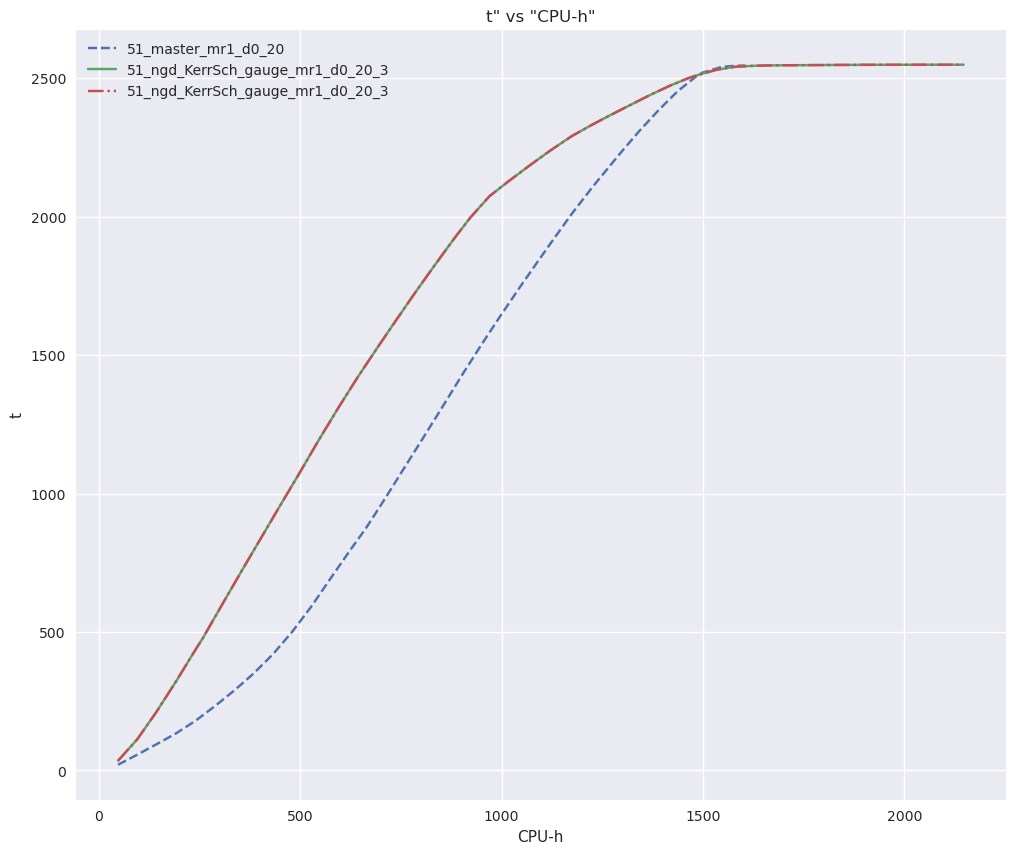

In [24]:
from cProfile import label
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/gauge_driver_mr3/Ev/Lev1_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/4_2908_KerrH_1_1_50_0_50_0_1_1_3/Ev/Lev0_A?/Run/TimeInfo.dat"
# run1 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/master_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
# run2 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/49_ngd_weird_gauge_mr1/Ev/Lev1_A?/Run/TimeInfo.dat"
# run3 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge/Ev/Lev1_A?/Run/TimeInfo.dat"
# run3 = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_10_05/Ev/Lev1_A?/Run/TimeInfo.dat"

lev = 3
run1 = f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_master_mr1_d0_20/Ev/Lev{lev}_A?/Run/TimeInfo.dat"
run2 = f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev{lev}_A?/Run/TimeInfo.dat"
run3 = f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/51_ngd_KerrSch_gauge_mr1_d0_20_3/Ev/Lev{lev}_A?/Run/TimeInfo.dat"
# run3 = f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/52_ngd_KerrSch_gauge_mr1_d0_13_05/Ev/Lev{lev}_A?/Run/TimeInfo.dat"

run1_dataA = read_dat_file_across_AA(run1)
run2_dataA = read_dat_file_across_AA(run2)
run3_dataA = read_dat_file_across_AA(run3)

# x_axis = "t"
x_axis = "CPU-h"
# y_label = "dt/dT"
# y_label = "dCPU-h/dt"
y_label = "t"

maxT = 10000
max_indx1 = len(run1_dataA["t"][run1_dataA["t"] < maxT])
max_indx2 = len(run2_dataA["t"][run2_dataA["t"] < maxT])
max_indx3 = len(run3_dataA["t"][run3_dataA["t"] < maxT])

plt.plot(run1_dataA[x_axis][:max_indx1],run1_dataA[y_label][:max_indx1],label=run1.split("/")[8],linestyle="dashed")
plt.plot(run2_dataA[x_axis][:max_indx2],run2_dataA[y_label][:max_indx2],label=run2.split("/")[8])
plt.plot(run3_dataA[x_axis][:max_indx3],run3_dataA[y_label][:max_indx3],label=run3.split("/")[8],linestyle="dashdot")


plt.xlabel(x_axis)
plt.ylabel(y_label)
title = y_label+"\" vs \""+x_axis+"\""
plt.title(title)
plt.legend()

fig_x_label = x_axis.replace("/","_")
fig_y_label = y_label.replace("/","_")
plt.savefig(f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/report_weird_gauge_vs_master_mr1/{fig_y_label}_vs_{fig_x_label}_"+run1.split("/")[-5]+"@@@"+run2.split("/")[-5]+"@@@"+run3.split("/")[-5]+"_"+f"T_t_{max_indx1}")

# Combine all paraview files into a single file

In [25]:
base_folder = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1ABonwards_vis"
# file_pattern = base_folder+"/Ev/Lev1_A?/Run/GaugeVis.pvd"
file_pattern = base_folder+"/Lev1_A[C-Z]/Run/GaugeVis.pvd"
output_path = base_folder + "/GaugeVis_Lev1.pvd"


combine_pvd_files(base_folder,file_pattern, output_path)

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1ABonwards_vis/Lev1_AC/Run/GaugeVis.pvd
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1ABonwards_vis/Lev1_AD/Run/GaugeVis.pvd
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/48_gd_weird_gauge_Lev1ABonwards_vis/Lev1_AE/Run/GaugeVis.pvd


In [26]:
# Combines all the pvd files into a single file and save it in the base folder
def combine_pvd_files(base_folder, file_pattern, output_path=None):

  if output_path is None:
    output_path = base_folder + "/GaugeVis.pvd"

  path_pattern = file_pattern
  path_collection = []


  for folder_name in glob.iglob(path_pattern, recursive=True):
      if os.path.isdir(folder_name) or os.path.isfile(folder_name):
          path_collection.append(folder_name)
          print(folder_name)


  with open(output_path,'w') as write_file:
    for i,file_path in enumerate(path_collection):
      with open(file_path,'r') as file:
        if(i==0):
          for lines in file.readlines()[:-2]:
            lines = lines.replace("GaugeVis",file_path[:-4])
            write_file.writelines(lines)

        elif (i==len(path_collection)-1):
          for lines in file.readlines()[3:]:
            lines = lines.replace("GaugeVis",file_path[:-4])
            write_file.writelines(lines)

        else:
          for lines in file.readlines()[3:-2]:
            if "</" in lines:
              continue
            lines = lines.replace("GaugeVis",file_path[:-4])
            write_file.writelines(lines)


```Python
# Create GaugeVis
command = f"cd {base_folder} && mkdir ./GaugeVis"
status = subprocess.run(command, capture_output=True, shell=True, text=True)
if status.returncode == 0:
  print(f"Succesfully created GaugeVis in {base_folder}")
else:
  sys.exit(
      f"GaugeVis creation failed in {base_folder} with error: \n {status.stderr}")

# Create GaugeVis subfolder
vtu_folder_path = base_folder+"/GaugeVis/GaugeVis"
command = f"mkdir {vtu_folder_path}"
status = subprocess.run(command, capture_output=True, shell=True, text=True)
if status.returncode == 0:
  print(f"Succesfully created {vtu_folder_path}")
else:
  sys.exit(
      f"GaugeVis creation failed as {vtu_folder_path} with error: \n {status.stderr}")


# Copy vtu files
GaugeVisFolder=[]

for paths in path_collection:
  GaugeVisFolder.append(paths[:-4])

for paths in GaugeVisFolder:
  command = f"cp {paths}/*.vtu {vtu_folder_path}/"
  status = subprocess.run(command, capture_output=True, shell=True, text=True)
  if status.returncode == 0:
    print(f"Succesfully copied vtu files from {paths}")
  else:
    sys.exit(
        f"Copying vtu files from {paths} failed with error: \n {status.stderr}")

```

# Profiler results

In [27]:
def JoinH5(h5_file_list, output_path, output_file_name):

  file_list_to_str = ""
  for h5file in h5_file_list:
    file_list_to_str += h5file + " "

  command = f"cd {output_path} && {spec_home}/Support/bin/JoinH5 -o {output_file_name} {file_list_to_str}"
  status = subprocess.run(command, capture_output=True, shell=True, text=True)
  if status.returncode == 0:
    print(f"Succesfully ran JoinH5 in {output_path}")
  else:
    sys.exit(
        f"JoinH5 failed in {output_path} with error: \n {status.stderr}")


def ExtractFromH5(h5_file, output_path):

  command = f"cd {output_path} && {spec_home}/Support/bin/ExtractFromH5 {h5_file}"
  status = subprocess.run(command, capture_output=True, shell=True, text=True)
  if status.returncode == 0:
    print(f"Succesfully ran ExtractFromH5 in {output_path}")
  else:
    sys.exit(
        f"ExtractFromH5 failed in {output_path} with error: \n {status.stderr}")



In [28]:
output_base_path= "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results"


base_folder = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/49_ngd_weird_gauge_mr1"
file_pattern = base_folder+"/Ev/Lev1_A?/Run/Profiler.h5"

path_pattern = file_pattern
path_collection = []

# make a folder in the output directory
save_folder = output_base_path+"/"+base_folder.split("/")[-1]
os.mkdir(save_folder)


# Find all the files that match the required pattern of the file
for folder_name in glob.iglob(path_pattern, recursive=True):
    if os.path.isdir(folder_name) or os.path.isfile(folder_name):
        path_collection.append(folder_name)
        print(folder_name)

JoinH5(path_collection,save_folder,"Profiler.h5")
ExtractFromH5("Profiler.h5",save_folder)

# Save path of all the summary files in extracted data

file_pattern = base_folder+"/Ev/Lev1_A?/Run/Profiler.h5"

path_pattern = file_pattern
path_collection = []

# Find all the files that match the required pattern of the file
for folder_name in glob.iglob(path_pattern, recursive=True):
    if os.path.isdir(folder_name) or os.path.isfile(folder_name):
        path_collection.append(folder_name)
        print(folder_name)

FileExistsError: [Errno 17] File exists: '/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1'

In [ ]:
# Find all the Summary files 
summary_file_pattern = save_folder+"/**/Summary.txt"
summary_file_collection = []

for file_path in glob.iglob(summary_file_pattern, recursive=True):
    if os.path.isdir(file_path) or os.path.isfile(file_path):
        summary_file_collection.append(file_path)
        print(file_path)

summary_file_collection.sort()

/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step10522.dir/Summary.txt
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step20070.dir/Summary.txt
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step24098.dir/Summary.txt
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step25740.dir/Summary.txt
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step25746.dir/Summary.txt
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step28151.dir/Summary.txt
/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step28182.d

In [ ]:
file_path = "/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/profiler_results/49_ngd_weird_gauge_mr1/extracted-Profiler/Step10522.dir/Summary.txt"



# Rough

In [ ]:
x = np.arange(100)/100
y1 = np.sin(x)
y2 = np.cos(x)

styles =  plt.style.available

for style in styles:
    print(style)
    plt.style.use(style)
    plt.plot(x,y1,label="y1asfasd")
    plt.plot(x,y2,label="y3asfasd")
    plt.title("asdf")
    plt.legend()
    plt.savefig(f"/panfs/ds09/sxs/himanshu/gauge_stuff/gauge_driver_runs/runs/make_report_del/{style}.png")
    plt.close()

In [ ]:
w = 4
print(np.convolve(np.arange(1,10),np.ones(w),'valid')/w)
print(np.arange(1,10))

[2.5 3.5 4.5 5.5 6.5 7.5]
[1 2 3 4 5 6 7 8 9]


In [ ]:
def moving_average(array,avg_len):
    return np.convolve(array,np.ones(avg_len))/avg_len